## Importing Libraries
**Importing the libraries needed to build this program**

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import plotly.express as px
import random

## Setting the folder paths of testing and training data into variables
**Doing this to imnprove code readability**

In [41]:
train_folder='traffic_Data/DATA'
test_folder='traffic_Data/TEST'
classes=pd.read_csv('labels.csv')
classSize=len(classes)
print(classSize)

58


## Defining a function to load the images and their respective labels into arrays

In [42]:
traffic_data = []
train_data=[]
labels = []

def fetch_image(traffic_data, labels):
    for classValue in os.listdir(train_folder):
        classPath=os.path.join(train_folder,classValue)
        labels.append(classValue)
        for trafficSignal in os.listdir(classPath):
            imgTrafficSignal=Image.open(os.path.join(classPath,trafficSignal))
            imgTrafficSignal = imgTrafficSignal.convert("L")
            imgTrafficSignal = imgTrafficSignal.resize((90,90))
            imgTrafficSignal = np.array(imgTrafficSignal)
            traffic_data.append((imgTrafficSignal,[int(classValue)]))
        
    labels=np.array(labels)
    return traffic_data,labels

## Spliting the training data into the features and labels respectively for model training
**Further splitting the features and labels into training and validation data (1/3rd of the dataset used for validation)**

In [43]:
traffic_data, labels = fetch_image(traffic_data, labels)
traffic_data_features, traffic_data_labels = zip(*traffic_data)
training_data_features, validation_data_features, training_data_labels, validation_data_labels = train_test_split(traffic_data_features, traffic_data_labels, test_size=0.33, random_state=42)
training_data_features = np.array(training_data_features)
training_data_labels = np.array(training_data_labels)
validation_data_features = np.array(validation_data_features)
validation_data_labels = np.array(validation_data_labels)
print(training_data_features.shape)
print(training_data_labels.shape)

(2793, 90, 90)
(2793, 1)


## Defining a neural network using tensorflow and keras 
**Using a Convolutional neural network as CNN's are particularly useful for finding patterns in images to recognize objects, classes, and categories**

In [44]:
cnnModel = Sequential()
cnnModel.add(Conv2D(16,(3,3), padding="same", input_shape=(90, 90, 1), activation='relu'))
print(cnnModel(training_data_features).shape)
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(32,(3,3), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(64,(5,5), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(128,(7,7), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Flatten())
cnnModel.add(Dense(232, activation='relu'))
cnnModel.add(Dense(116, activation='relu'))
cnnModel.add(Dense(58, activation='softmax'))

(2793, 90, 90, 16)


In [45]:
cnnModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 90, 90, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 23, 23, 64)        51264     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 12, 12, 64)       

## Compiling and fitting the model to the training data

In [71]:
cnnModel.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
trafficSignNetwork = cnnModel.fit(training_data_features, training_data_labels, batch_size=14, epochs=12, validation_data=(validation_data_features, validation_data_labels))

Epoch 1/12


c:\Users\mustu\anaconda3\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


200/200 [==============================] - 7s 28ms/step - loss: 0.1290 - accuracy: 0.9696 - val_loss: 0.4056 - val_accuracy: 0.9521
Epoch 2/12
200/200 [==============================] - 5s 25ms/step - loss: 0.0447 - accuracy: 0.9846 - val_loss: 0.4265 - val_accuracy: 0.9405
Epoch 3/12
200/200 [==============================] - 5s 25ms/step - loss: 0.1201 - accuracy: 0.9681 - val_loss: 0.7562 - val_accuracy: 0.9194
Epoch 4/12
200/200 [==============================] - 5s 25ms/step - loss: 0.1028 - accuracy: 0.9764 - val_loss: 0.3786 - val_accuracy: 0.9463
Epoch 5/12
200/200 [==============================] - 5s 25ms/step - loss: 0.0751 - accuracy: 0.9835 - val_loss: 0.4838 - val_accuracy: 0.9187
Epoch 6/12
200/200 [==============================] - 5s 25ms/step - loss: 0.1006 - accuracy: 0.9814 - val_loss: 0.3059 - val_accuracy: 0.9542
Epoch 7/12
200/200 [==============================] - 5s 25ms/step - loss: 0.0108 - accuracy: 0.9964 - val_loss: 0.2959 - val_accuracy: 0.9651
Epoch 8/12

## Graphical Representation of the accuracy of the model over the epochs

In [72]:
import seaborn as sns

<Axes: >

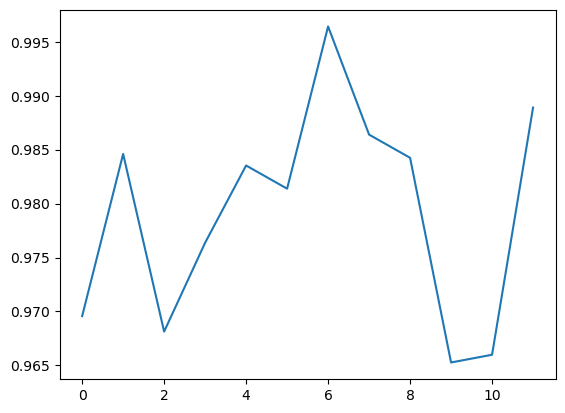

In [73]:
sns.lineplot(trafficSignNetwork.history['accuracy'])

## Testing the model on unseen data 

In [74]:
test_data=[]
for test_image_file in os.listdir(test_folder):
    testImage=Image.open(os.path.join(test_folder,test_image_file))
    testImage=testImage.convert('L')
    testImage=testImage.resize((90,90))
    testImage=np.array(testImage)
    test_data.append((testImage,[int(test_image_file[1:3])]))

test_data_features, test_data_labels= zip(*test_data)
test_data_features=np.array(test_data_features)
test_data_labels=np.array(test_data_labels)

In [75]:
predictions=cnnModel.predict(test_data_features)
predictions

63/63 [==============================] - 1s 15ms/step


array([[2.76383851e-03, 8.65285656e-08, 5.43413160e-04, ...,
        3.72789538e-04, 2.06730983e-04, 7.86447163e-06],
       [9.99997735e-01, 7.83427685e-13, 4.76825948e-18, ...,
        1.23013665e-36, 2.49933293e-13, 9.86359112e-23],
       [9.99919415e-01, 2.84140802e-15, 7.02362837e-14, ...,
        1.11642861e-28, 5.07714149e-10, 8.29800459e-17],
       ...,
       [3.03119418e-28, 1.06210974e-30, 6.24695135e-20, ...,
        1.18974979e-25, 6.24149648e-20, 1.00000000e+00],
       [4.17937367e-21, 4.31690846e-23, 5.12721643e-16, ...,
        1.26883498e-21, 1.83669438e-15, 1.00000000e+00],
       [3.03119418e-28, 1.06210974e-30, 6.24695135e-20, ...,
        1.18974979e-25, 6.24149648e-20, 1.00000000e+00]], dtype=float32)

In [76]:
predicted_labels=np.argmax(predictions, axis=1)

In [77]:
predicted_labels

array([32,  0,  0, ..., 57, 57, 57], dtype=int64)

In [78]:
print(classes['Name'][predicted_labels])

32           Road Divider
0     Speed limit (5km/h)
0     Speed limit (5km/h)
0     Speed limit (5km/h)
0     Speed limit (5km/h)
             ...         
56               Unknown7
57               Unknown8
57               Unknown8
57               Unknown8
57               Unknown8
Name: Name, Length: 1994, dtype: object


In [79]:
print(classes['Name'][test_data_labels[:,0]])

0     Speed limit (5km/h)
0     Speed limit (5km/h)
0     Speed limit (5km/h)
0     Speed limit (5km/h)
0     Speed limit (5km/h)
             ...         
56               Unknown7
57               Unknown8
57               Unknown8
57               Unknown8
57               Unknown8
Name: Name, Length: 1994, dtype: object


## Saving the model in both .h5 and .keras file formats for use in applications

In [88]:
cnnModel.save("model.h5")

c:\Users\mustu\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [89]:
cnnModel.save("model.keras")